In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
# import vegas
#import pandas as pd



In [9]:
# constants
M_sun = 1.9891e30 # solar mass in kg
yr2s = 31556926 # year in seconds
G = 6.67430e-11 # Newton gravity constant, m^3/kg/s^2
mp = 1.6726e-27 # proton mass, kg
kB = 1.38064e-23 # Boltzman constant, m^2 kg /s^2 /K
K2MeV = 1000 / 1.161e13 # Kelvin to MeV
K2erg = 1.3806e-16 # Kelvin to erg
MeV2kg = 1.783e-30 # MeV to kg
light_speed = 29979245800 # cm/s
M_sun_erg = 1.79e54 # solar mass to erg
g2erg = 8.987e20 # 1 gram to erg
cm3_2_perMeV3 = (1/1.973e-11)**3
kB_MeV = 8.617e-11 # MeV/K

The sound speed $c_s$ at different layer $r$ of CSM is defined as
$$
c_s(r) = \sqrt{\frac{\gamma P(r)}{\rho(r)}}
$$
where the adiabatic index $\gamma = 5/3$ for monatomic gas, e.g., H<sup>+</sup> and He. The CSM density
$$
\rho(r) = \frac{\dot{M}}{4\pi r^2 v_w}
$$
and $\dot{M}$ is the mass-loss rate as well as $v_w$ the wind velocity.
The local dynamical timescale $\tau_d$ thus approximates
$$
\tau_d(r)=\frac{r}{c_s(r)}.
$$

For simplicity, assuming $T$ is a constant and CSM is an ideal gas, then
$$
P(r)=n(r)k_B T = \frac{\rho(r)}{m} k_B T
$$
where $m$ is the mass of the particle. Suppose CSM has a constant temperature (~$10^3~{\rm K}$), then
$$
c_s = \sqrt{\gamma \frac{k_B T}{m}}
$$
is also a constant.

In [13]:
def CSM_density(r,Mdot,vw):
    """
    CSM density

    Parameters
    ----------
    r : scalar
        CSM radii, cm
    Mdot : scalar
        Mass-loss rate, M_sun/yr
    vw : scalar
        Wind velocity, km/s

    Returns
    -------
    out : scalar
        CSM density, g/cm^3
    """
    vw = vw * 1e5 # convert km/s to cm/s
    Mdot = Mdot * M_sun * 1000 / yr2s # convert M_sun/yr to g/s
    rho = Mdot / 4 / np.pi / r**2 / vw 
    return rho

def CSM_sound_speed(T,m,gamma=5/3):
    """
    CSM sound speed

    Parameters
    ----------
    T : scalar
        CSM temperature, K
    m : scalar
        Mass of the CSM component, MeV
    gamma : scalar
        Adiabatic index, default 5/3

    Returns
    -------
    out : scalar
        CSM sound speed c_s, km/s
    """
    m = m * MeV2kg
    cs = np.sqrt(gamma * kB * T / m)
    return cs / 1000 # convert m/s to km/s

def CSM_dynamical_time(r,T,m,gamma=5/3):
    """
    CSM dynamical timescale

    Parameters
    ----------
    r : scalar
        CSM radii, cm
    T : scalar
        CSM temperature, K
    m : scalar
        Mass of the CSM component, MeV
    gamma : scalar
        Adiabatic index, default 5/3

    Returns
    -------
    out : scalar
        CSM dynamical timescale t_d, s
    """
    r = r / 1e5 # convert cm to km
    cs = CSM_sound_speed(T,m,gamma)
    td = r / cs
    return td

In [39]:
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt')).T
rho_interp = interp1d(rho_data[0],rho_data[1],
                      kind='cubic',
                      bounds_error=False,
                      fill_value=0)
max_r = 10**rho_data[0][-1]
min_r = 10**rho_data[0][0]
def CSM_density_real(r):
    """
    g/cm^3
    """
    r = np.log10(r)
    return 10**rho_interp(r)

In [19]:
T = 1000 # K
m = 938 # MeV, proton
csm_radii = np.logspace(rho_data[0][0],rho_data[0][-1],100)

Text(0.5, 1.0, '$T=1000$ K, $m=m_p$ and $\\gamma=\\frac{5}{3}$')

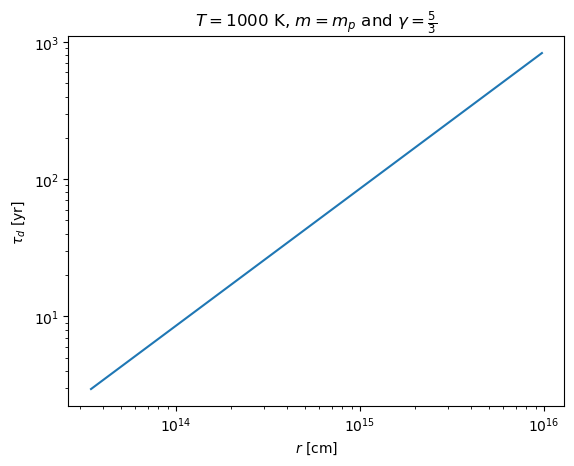

In [21]:
plt.plot(csm_radii,CSM_dynamical_time(csm_radii,T,m)/yr2s)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\tau_d$ [yr]')
plt.title(r'$T=1000$ K, $m=m_p$ and $\gamma=\frac{5}{3}$')

Text(0, 0.5, '$\\rho$ [g cm$^{-3}$]')

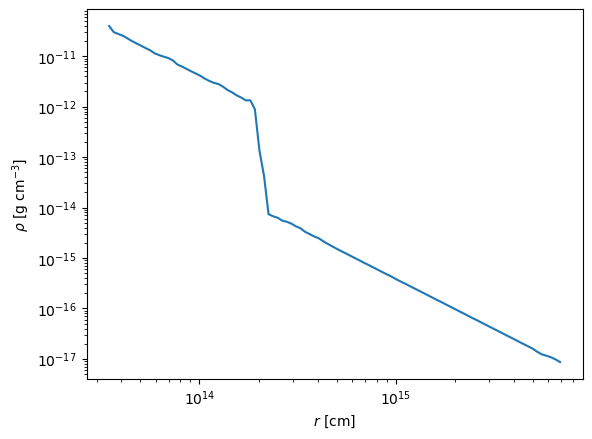

In [33]:
plt.plot(csm_radii,CSM_density_real(csm_radii))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\rho$ [g cm$^{-3}$]')
#plt.title(r'$T=1000$ K, $m=m_p$ and $\gamma=\frac{5}{3}$')

In [15]:
# load stopping power data
stop_power_e_H_data = np.loadtxt('stopping_power/electron_H.txt',skiprows=8).T
stop_power_e_He_data = np.loadtxt('stopping_power/electron_He.txt',skiprows=8).T
# interpolate, in log-scale
stop_power_e_H = interp1d(np.log10(stop_power_e_H_data[0]),np.log10(stop_power_e_H_data[-1]))
stop_power_e_He = interp1d(np.log10(stop_power_e_He_data[0]),np.log10(stop_power_e_He_data[-1]))

def stopping_power_electron(Ek,target='H'):
    """
    Stopping power for electron in different target

    Parameters
    ----------
    Ek : scalar
        Electron kinetic energy, MeV (valid from 0.01 MeV to 1000 MeV)
    target : str
        Target that the electron is interacting with, 'H' or 'He'

    Returns
    -------
    out : scalar
        Electron stopping power, MeV cm^2/g
    """
    logEk = np.log10(Ek)
    if target == 'H':
        sp = 10**(stop_power_e_H(logEk))
    elif target == 'He':
        sp = 10**(stop_power_e_He(logEk))
    else:
        raise ValueError('\'target\' must be either \'H\' or \'He\'.')
    return sp

# load mass-absorption data for photon
mass_abs_photon_H_data = np.loadtxt('stopping_power/mass_attn_photon_H.txt',skiprows=8).T
# interpolate, in log-scale
mass_abs_photon_H = interp1d(np.log10(mass_abs_photon_H_data[0]),np.log10(mass_abs_photon_H_data[-2]))

def mass_absorption_photon(Eg,target='H'):
    """
    Mass-absorption coefficient for photon in different target

    Parameters
    ----------
    Eg : scalar
        Photon energy, MeV (valid from 0.001 MeV to 100 MeV)
    target : str
        Target that the electron is interacting with, 'H' or 'He'

    Returns
    -------
    out : scalar
        Mass-absorption coefficient, cm^2/g
    """
    logEg = np.log10(Eg)
    if target == 'H':
        ma = 10**(mass_abs_photon_H(logEg))
    elif target == 'He':
        ma = 10**(mass_abs_photon_He(logEk))
    else:
        raise ValueError('\'target\' must be either \'H\' or \'He\'.')
    return ma

In [19]:
def heating_time(Ek,r,Mdot,vw,target='H'):
    """
    Electron heating time

    Parameters
    ----------
    Ek : scalar
        Initial electron energy, MeV
    r : scalar
        CSM radii, cm
    Mdot : scalar
        Mass-loss rate, M_sun/yr
    vw : scalar
        Wind velocity, km/s
    target : str
        Target that the electron is interacting with, 'H' or 'He'

    Returns
    -------
    out : tup
        Stopping time (s), stopping length (cm)
    """
    rho = CSM_density(r,Mdot,vw)
    S = stopping_power_electron(Ek,target) # stopping power, MeV cm^2/g
    stop_length = Ek / S / rho # travel distance for electron to deposit all its kinetic energy to the ambient target
    stop_time = stop_length / light_speed
    return stop_time,stop_length

def heating_time_real(Ek,r,target='H'):
    """
    Electron heating time with realistic CSM density profile

    Parameters
    ----------
    Ek : scalar
        Initial electron energy, MeV
    r : scalar
        CSM radii, cm
    target : str
        Target that the electron is interacting with, 'H' or 'He'

    Returns
    -------
    out : tup
        Stopping time (s), stopping length (cm)
    """
    rho = CSM_density_real(r)
    S = stopping_power_electron(Ek,target) # stopping power, MeV cm^2/g
    stop_length = Ek / S / rho # travel distance for electron to deposit all its kinetic energy to the ambient target
    stop_time = stop_length / light_speed
    return stop_time,stop_length

def absorption_length_photon_real(Eg,r,target='H'):
    """
    Photon absorption length with realistic CSM density profile

    Parameters
    ----------
    Eg : scalar
        Initial photon energy, MeV
    r : scalar
        CSM radii, cm
    target : str
        Target that the photon is interacting with, 'H' or 'He'

    Returns
    -------
    out : tup
        Absorption length (cm)
    """
    rho = CSM_density_real(r)
    mu = mass_absorption_photon(Eg,target) * rho # attenuation length, cm^2/g * g/cm^3 = 1/cm
    abs_length = 1/ mu
    return abs_length

In [136]:
CSM_density_real(7e13)

8.219282816476662e-12

In [140]:
1/absorption_length_photon_real(10,7e13,target='H')

2.6745546284815055e-13

In [122]:
-1/0.0534

-18.726591760299623

The stopping length
$$
\ell_{\rm stop} = \frac{E_0}{{\dot E}}
$$
where ${\dot E}$ is the stopping power (${\rm MeV~cm}^{-1}$), which can be calculated by
$$
{\dot E} = S(E_0) \times \rho 
$$
with $\rho$ is the ambient medium density and $S$ has a dimension ${\rm MeV~cm^{2}~g^{-1}}$ and can be obtained from NIST data.
Thus the heating time
$$
\tau_h=\frac{\ell_{\rm stop}}{c}
$$
where $c $ is the speed of light.

In [27]:
Mdot = 0.01 # M_sun/yr
vw = 20 # km/s
tau_h_10 = [heating_time(10,r,Mdot,vw,target='H')[0] for r in csm_radii]
tau_h_100 = [heating_time(100,r,Mdot,vw,target='H')[0] for r in csm_radii]

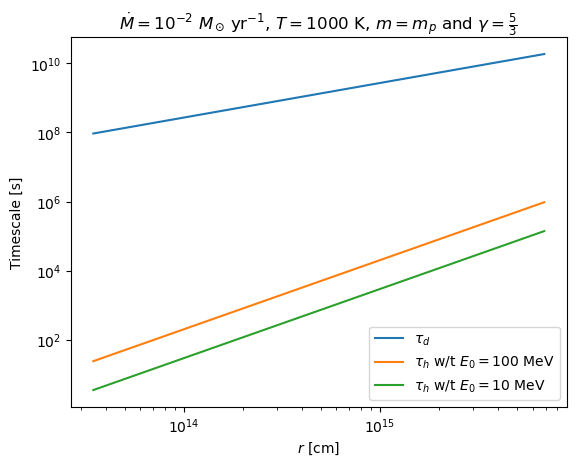

In [25]:
plt.plot(csm_radii,CSM_dynamical_time(csm_radii,T,m),label=r'$\tau_d$')

plt.plot(csm_radii,tau_h_100,label=r'$\tau_h$ w/t $E_0=100$ MeV')
plt.plot(csm_radii,tau_h_10,label=r'$\tau_h$ w/t $E_0=10$ MeV')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'Timescale [s]')
plt.title(r'$\dot{M}=10^{-2}~M_\odot\,{\rm yr}^{-1}$, $T=1000$ K, $m=m_p$ and $\gamma=\frac{5}{3}$')
plt.legend(loc='lower right')
#plt.savefig('timescale.pdf',bbox_inches='tight')

In [29]:
tau_h_10_real = [heating_time_real(10,r)[0] for r in csm_radii]
tau_h_100_real = [heating_time_real(100,r)[0] for r in csm_radii]

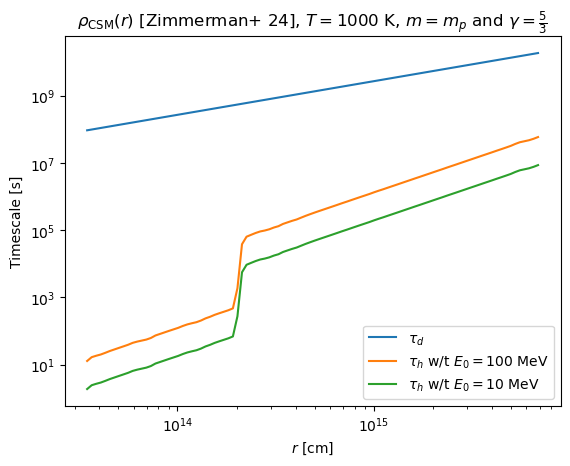

In [35]:
plt.plot(csm_radii,CSM_dynamical_time(csm_radii,T,m),label=r'$\tau_d$')

plt.plot(csm_radii,tau_h_100_real,label=r'$\tau_h$ w/t $E_0=100$ MeV')
plt.plot(csm_radii,tau_h_10_real,label=r'$\tau_h$ w/t $E_0=10$ MeV')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'Timescale [s]')
plt.title(r'$\rho_{\rm CSM}(r)$ [Zimmerman+ 24], $T=1000$ K, $m=m_p$ and $\gamma=\frac{5}{3}$')
plt.legend(loc='lower right')
#plt.savefig('timescale_real.pdf',bbox_inches='tight')

The CSM velocity after DP energy injection is
$$
v_{\rm CSM}=\sqrt{\frac{2E}{\dot{M}}\frac{v_w}{R_{\rm CSM}}}
$$
where $R_{\rm CSM}\approx 3\times 10^{14}~{\rm cm}$ is the CSM radius. 

In [23]:
def CSM_velocity(Einj,Mdot,vw,R_CSM):
    """
    Electron heating time

    Parameters
    ----------
    Einj : scalar
        Total DP energy injection, erg
    Mdot : scalar
        Mass-loss rate, M_sun/yr
    vw : scalar
        Wind velocity, km/s
    R_CSN : scalar
        Maximum CSM radius, cm

    Returns
    -------
    out : scalar
        CSN velocity after DP energy injection, km/s
    """
    Mdot = Mdot * M_sun_erg / yr2s # convert M_sun/yr to erg/s
    R_CSM = R_CSM / 1e5 # convert cm to km
    v_CSM = np.sqrt(2 * Einj * vw / Mdot / R_CSM) # dimensionless velocity
    v_CSM = v_CSM * light_speed / 1e5 # convert dimensionless velocity to km/s
    return v_CSM

In [33]:
vw = 25 #km/s
R_CSM = 3e14 # cm
E_inj = np.logspace(41,49,100)
M_dot = [1e-7,1e-5,1e-3,1e-1]
labels = [r'$\dot{M}=10^{-7}$',r'$\dot{M}=10^{-5}$',r'$\dot{M}=10^{-3}$',r'$\dot{M}=10^{-1}$']
# SN 2023ixf constraint
E_inj_cons = [E_inj[0],E_inj[-1]]
v_CSM_upper = [115,115]
v_CSM_lower = [10,10]

Text(0.5, 1.0, '$v_w=25$ km s$^{-1}$')

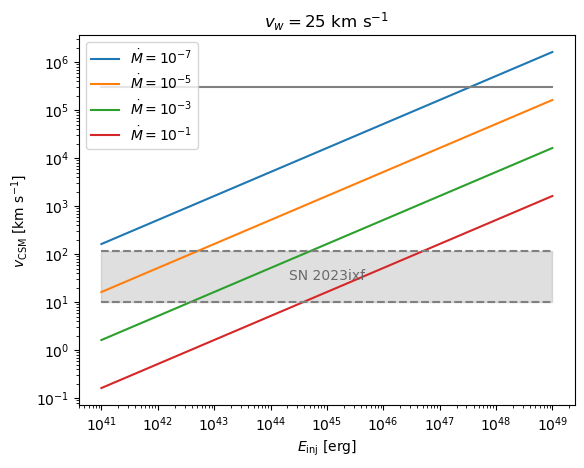

In [41]:
for i in range(4):
    Mdot = M_dot[i]
    label = labels[i]
    v_csm = CSM_velocity(E_inj,Mdot,vw,R_CSM)
    plt.plot(E_inj,v_csm,label=label)

plt.plot(E_inj_cons,[light_speed / 1e5,light_speed / 1e5],color='gray')

plt.plot(E_inj_cons,v_CSM_upper,'--',color='gray')
plt.plot(E_inj_cons,v_CSM_lower,'--',color='gray')
plt.fill_between(
    E_inj_cons,       # The X-axis range
    v_CSM_lower,      # The lower boundary
    v_CSM_upper,      # The upper boundary
    color='grey',
    alpha=0.25, # Transparency level
    #label='Filled Region'
)
plt.text(x=1e45,
         y=35,
         s='SN 2023ixf',
         horizontalalignment='center',
         verticalalignment='center',
         color='dimgray')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$E_{\rm inj}$ [erg]')
plt.ylabel(r'$v_{\rm CSM}$ [km s$^{-1}$]')
plt.title(r'$v_w=25$ km s$^{-1}$')
#plt.savefig('v_CSM.pdf',bbox_inches='tight')

For realistic case
$$
M_{\rm CSM} = 4\pi \int_{r_{\rm min}}^{r_{\rm max}}dr\, r^2 \rho(r)dr
$$
thus
$$
v_{\rm CSM}=\sqrt{\frac{2E}{M_{\rm CSM}}}
$$

In [25]:
def CSM_velocity_real(Einj,M_CSM):
    v_csm = np.sqrt(2 * Einj / M_CSM) * light_speed / 1e5 # convert dimensionless velocity to km/s
    return v_csm

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_19027/320908466.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM = 4 * np.pi * quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r)[0] * 8.9876e20 # convert gram to erg


Text(0.5, 1.0, '$v_w=25$ km s$^{-1}$')

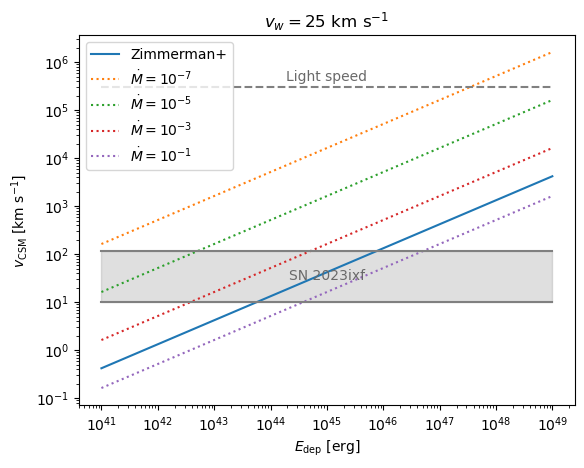

In [37]:
M_CSM = 4 * np.pi * quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r)[0] * 8.9876e20 # convert gram to erg
v_csm_real = CSM_velocity_real(E_inj,M_CSM)

plt.plot(E_inj,v_csm_real,label='Zimmerman+')
for i in range(4):
    Mdot = M_dot[i]
    label = labels[i]
    v_csm = CSM_velocity(E_inj,Mdot,vw,R_CSM)
    plt.plot(E_inj,v_csm,':',label=label)




plt.plot(E_inj_cons,[light_speed / 1e5,light_speed / 1e5],'--',color='gray')

plt.plot(E_inj_cons,v_CSM_upper,color='gray')
plt.plot(E_inj_cons,v_CSM_lower,color='gray')
plt.fill_between(
    E_inj_cons,       # The X-axis range
    v_CSM_lower,      # The lower boundary
    v_CSM_upper,      # The upper boundary
    color='grey',
    alpha=0.25, # Transparency level
    #label='Filled Region'
)
plt.text(x=1e45,
         y=35,
         s='SN 2023ixf',
         horizontalalignment='center',
         verticalalignment='center',
         color='dimgray')

plt.text(x=1e45,
         y=5e5,
         s='Light speed',
         horizontalalignment='center',
         verticalalignment='center',
         color='dimgray')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$E_{\rm dep}$ [erg]')
plt.ylabel(r'$v_{\rm CSM}$ [km s$^{-1}$]')
plt.title(r'$v_w=25$ km s$^{-1}$')
#plt.savefig('v_CSM_real.pdf',bbox_inches='tight')

The broaden spectrum
$$
\frac{\Delta \lambda}{\lambda}=\frac{2 v_{\rm CSM}}{c}.
$$
For ${\rm H}\alpha$ emission line $\lambda \approx 6563 ~{\rm A}$.

In [24]:
def delta_lambda(wavelength,v_csm):
    return 2 * v_csm * 1e5 / light_speed * wavelength 

In [25]:
csm_velocity = np.logspace(-1,5,100)

Text(0.5, 0, '$v_{\\rm CSM}$ [km s$^{-1}$]')

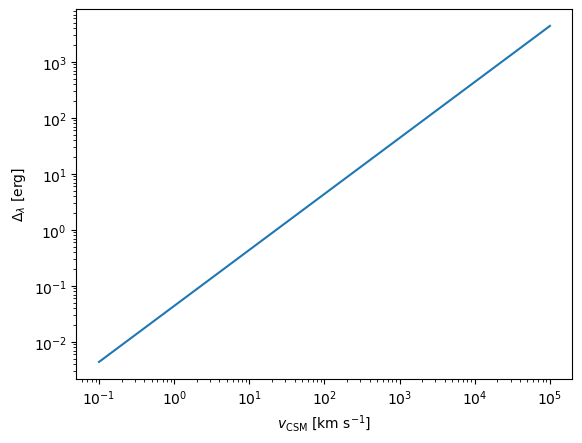

In [26]:
delta_l = delta_lambda(6563,csm_velocity)
plt.plot(csm_velocity,delta_l)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\Delta_\lambda$ [erg]')
plt.xlabel(r'$v_{\rm CSM}$ [km s$^{-1}$]')

In [27]:
delta_lambda(6563,500)

21.89181156785472

### CSM velocity in terms of DP energy deposition

The DP energy deposition rate per layer  $dQ/dr$ is shown in the following figure.

<center>
<img src="dQ_dr.png" width="30%">
</center>

Assuming the depsition time is $t_{\rm dep}$, the energy deposition rate per layer is thus $dE_{\rm dep}=t_{\rm dep}(dQ/dr)dr$.
The CSM velocity at each layer is
$$
v_{\rm CSM}(r) = \sqrt{\frac{2dE_{\rm dep}}{dM_{\rm CSM}}}c=\sqrt{\frac{t_{\rm dep}dQ/dr}{2\pi r^2 \rho(r)}}c
$$

In [27]:
# DP energy deposition rate at layer r
dQdr_data = np.log10(np.loadtxt('dQdr_r.dat',skiprows=1).T) # dQdr data in log-log scale
dQdr_interp = interp1d(dQdr_data[0],dQdr_data[1],
                      kind='cubic',
                      bounds_error=False,
                      fill_value=0)
def dQdr_DP(r):
    """
    erg/cm/s
    """
    r = np.log10(r)
    return 10**dQdr_interp(r)

Text(0.5, 1.0, '$m_{A^\\prime}=5$ MeV, $\\varepsilon=10^{-12}$')

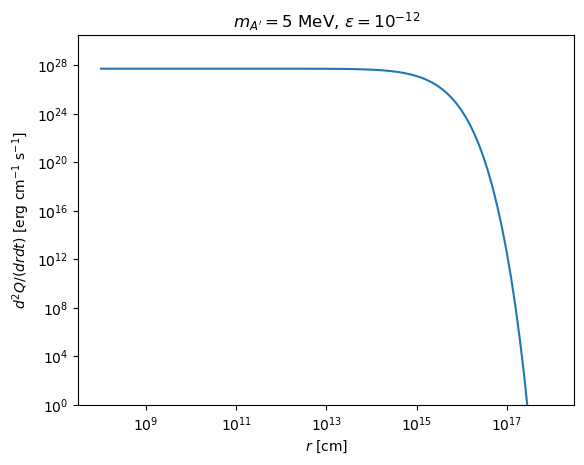

In [72]:
r_DP = np.logspace(8,18,100)
plt.plot(r_DP,dQdr_DP(r_DP))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,)
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$d^2Q/(drdt)$ [erg cm$^{-1}$ s$^{-1}$]')
plt.title(r'$m_{A^\prime}=5$ MeV, $\varepsilon=10^{-12}$')

In [21]:
def CSM_velocity_r_DP(r,tdep,dQdr):
    """
    CSM velocity at layer r in terms of DP energy deposition dQ/dr

    Parameters
    ----------
    r : scalar
        Layer r of CSM, cm
    tdep : scalar
        DP energy depostion time, s
    dQdr : func
        DP energy deposition rate per layer, func(r) with erg/cm/s
    
    Returns
    -------
    out : scalar
        CSM velocity at layer r, km/s
    """
    rho = CSM_density_real(r) * g2erg # CSM density at r, erg/cm^3
    dE = dQdr(r) * tdep # energy deposition at layer r, erg
    v_csm = np.sqrt(dE / 2 / np.pi / r**2 / rho) * light_speed / 1e5 # CSM velocity, km/s
    return v_csm

In [23]:
CSM_radii = np.logspace(np.log10(min_r),np.log10(max_r),100)
v_csm = CSM_velocity_r_DP(CSM_radii,100,dQdr_DP)

# constraint
E_csm_cons = [CSM_radii[0],CSM_radii[-1]]

Text(0.5, 1.0, '$m_{A^\\prime}=5$ MeV, $\\varepsilon=10^{-12}$ and $t_{\\rm dep}=100$ s')

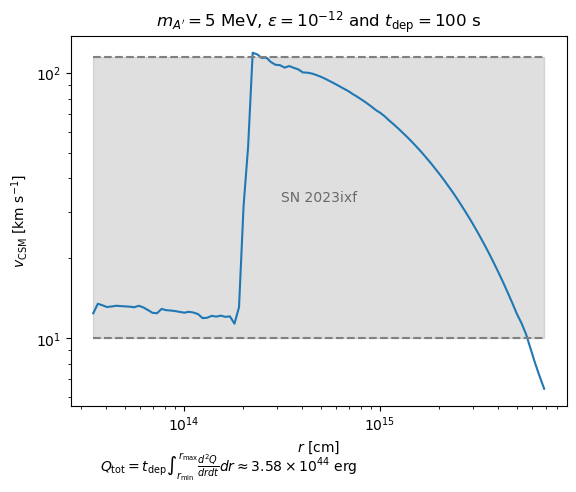

In [78]:
plt.plot(CSM_radii,v_csm)

plt.plot(E_csm_cons,v_CSM_upper,'--',color='gray')
plt.plot(E_csm_cons,v_CSM_lower,'--',color='gray')
plt.fill_between(
    E_csm_cons,       # The X-axis range
    v_CSM_lower,      # The lower boundary
    v_CSM_upper,      # The upper boundary
    color='grey',
    alpha=0.25, # Transparency level
    #label='Filled Region'
)
plt.text(x= 10**((np.log10(CSM_radii[-1]) - np.log10(CSM_radii[0])) / 2 + np.log10(CSM_radii[0])),
         y= 10**((np.log10(v_CSM_upper[0]) - np.log10(v_CSM_lower[0])) / 2 + np.log10(v_CSM_lower[0])),
         s='SN 2023ixf',
         horizontalalignment='center',
         verticalalignment='center',
         color='dimgray')

plt.text(x= 1.7e14,
         y= 3.3,
         s=r'$Q_{\rm tot}=t_{\rm dep}\int_{r_{\rm min}}^{r_{\rm max}}\frac{d^2Q}{drdt}dr\approx 3.58\times 10^{44}$ erg',
         horizontalalignment='center',
         verticalalignment='center',)



plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$v_{\rm CSM}$ [km s$^{-1}$]')
plt.title(r'$m_{A^\prime}=5$ MeV, $\varepsilon=10^{-12}$ and $t_{\rm dep}=100$ s')
#plt.savefig('csm_velocity.pdf',bbox_inches='tight')

In [34]:
integ = vegas.Integrator([[1e8,1e18]])

In [35]:
integ(dQdr_DP,neval=10000)

RAvgArray([3.749603(29)e+42], dtype=object)

In [36]:
(np.log10(v_CSM_upper) - np.log10(v_CSM_lower)) / 2 + np.log10(v_CSM_lower)

array([1.53034892, 1.53034892])

In [37]:
v_CSM_upper

[115, 115]

In [38]:
integ(lambda x: 4*np.pi*CSM_density_real(x[0])*x[0]**2,neval=10000)

4.189905(47)e+54

In [39]:
np.sqrt(2*3.5824e44/1.256e32/g2erg) * light_speed / 1e5

23.88474166350463

In [40]:
1.256e32*g2erg

1.1287672e+53

In [45]:
r_rsg = np.logspace(np.log10(min_r),np.log10(max_r),100)
r_bsg = np.logspace(12,17,100)
vw_bsg = 200
Mdot_bsg1 = 1e-5
Mdot_bsg2 = 1e-4
csm_bsg1 = CSM_density(r_bsg,Mdot_bsg1,vw_bsg)
csm_bsg2 = CSM_density(r_bsg,Mdot_bsg2,vw_bsg)
csm_sn2023ixf = CSM_density_real(r_rsg)

Text(0, 0.5, '$\\rho$ [g cm$^{-3}$]')

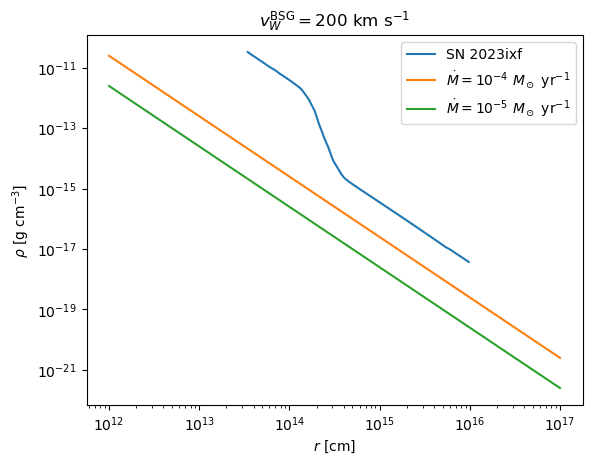

In [47]:
plt.plot(r_rsg,csm_sn2023ixf,label='SN 2023ixf')
plt.plot(r_bsg,csm_bsg2,label=r'$\dot{M}=10^{-4}~M_\odot~{\rm yr}^{-1}$')
plt.plot(r_bsg,csm_bsg1,label=r'$\dot{M}=10^{-5}~M_\odot~{\rm yr}^{-1}$')

plt.xscale('log')
plt.yscale('log')
plt.title(r'$v_W^{\rm BSG}=200$ km s$^{-1}$')
plt.legend()
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\rho$ [g cm$^{-3}$]')

In [29]:
def bsgCSM_velocity_r_DP(r,Mdot,vw,tdep,dQdr):
    """
    BSG CSM velocity at layer r in terms of DP energy deposition dQ/dr

    Parameters
    ----------
    r : scalar
        Layer r of CSM, cm
    Mdot : scalar
        Mass-loss rate, M_sun/yr
    vw : scalar
        Wind velocity, km/s
    tdep : scalar
        DP energy depostion time, s
    dQdr : func
        DP energy deposition rate per layer, func(r) with erg/cm/s
    
    Returns
    -------
    out : scalar
        CSM velocity at layer r, km/s
    """
    rho = CSM_density(r,Mdot,vw) * g2erg # CSM density at r, erg/cm^3
    dE = dQdr(r) * tdep # energy deposition at layer r, erg
    v_csm = np.sqrt(dE / 2 / np.pi / r**2 / rho) * light_speed / 1e5 # CSM velocity, km/s
    return v_csm

In [27]:
v_bsgcsm1 = bsgCSM_velocity_r_DP(r_bsg,Mdot_bsg1,vw_bsg,100,dQdr_DP)
v_bsgcsm2 = bsgCSM_velocity_r_DP(r_bsg,Mdot_bsg2,vw_bsg,100,dQdr_DP)

NameError: name 'r_bsg' is not defined

NameError: name 'E_csm_cons' is not defined

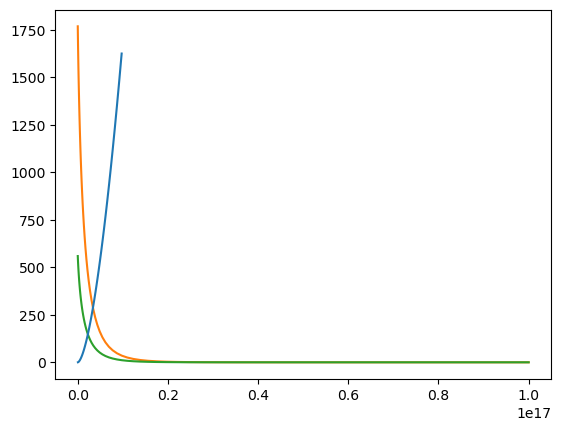

In [61]:
plt.plot(r_bsg,v_bsgcsm1,color='C1',label=r'BSG $\dot{M}=10^{-5}\,M_\odot\,{\rm yr}^{-1}$')
plt.plot(r_bsg,v_bsgcsm2,color='C2',label=r'BSG $\dot{M}=10^{-4}\,M_\odot\,{\rm yr}^{-1}$')
plt.plot(CSM_radii,v_csm,color='C0',label='SN 2023ixf')


plt.plot(E_csm_cons,v_CSM_upper,'--',color='gray')
plt.plot(E_csm_cons,v_CSM_lower,'--',color='gray')
plt.fill_between(
    E_csm_cons,       # The X-axis range
    v_CSM_lower,      # The lower boundary
    v_CSM_upper,      # The upper boundary
    color='grey',
    alpha=0.25, # Transparency level
    #label='Filled Region'
)
plt.text(x= 10**((np.log10(CSM_radii[-1]) - np.log10(CSM_radii[0])) / 2 + np.log10(CSM_radii[0])),
         y= 10**((np.log10(v_CSM_upper[0]) - np.log10(v_CSM_lower[0])) / 2 + np.log10(v_CSM_lower[0])),
         s='SN 2023ixf',
         horizontalalignment='center',
         verticalalignment='center',
         color='dimgray')

# bsg
plt.plot([1e12,1e17],[500,500],'--',color='slateblue')
plt.plot([1e12,1e17],[90,90],'--',color='slateblue')
plt.fill_between(
    [1e12,1e17],       # The X-axis range
    [90,90],      # The lower boundary
    [500,500],      # The upper boundary
    color='slateblue',
    alpha=0.25, # Transparency level
    #label='Filled Region'
)

plt.text(x= 10**14.5,
         y= 10**((np.log10(500)-np.log10(90))/2+np.log10(90)),
         s=r'LBV',
         color='slateblue',
         horizontalalignment='center',
         verticalalignment='center',)

plt.legend()
plt.ylim(5.5,4500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$v_{\rm CSM}$ [km s$^{-1}$]')
plt.title(r'$m_{A^\prime}=5$ MeV, $\varepsilon=10^{-12}$ and $t_{\rm dep}=100$ s')
#plt.savefig('v_CSM_bsg.png',bbox_inches='tight',dpi=300)

In [86]:
#int_length_bsgcsm1 = heating_time(10,r_bsg,Mdot_bsg1,vw_bsg)[1]
#int_length_bsgcsm2 = heating_time(10,r_bsg,Mdot_bsg2,vw_bsg)[1]
int_length_real = heating_time_real(0.5,CSM_radii)[1]
abs_length_real = absorption_length_photon_real(0.5,CSM_radii)
abs_length_real_20 = absorption_length_photon_real(20,CSM_radii)

Text(0.5, 1.0, 'Photon atteunation length: SN 2023ixf')

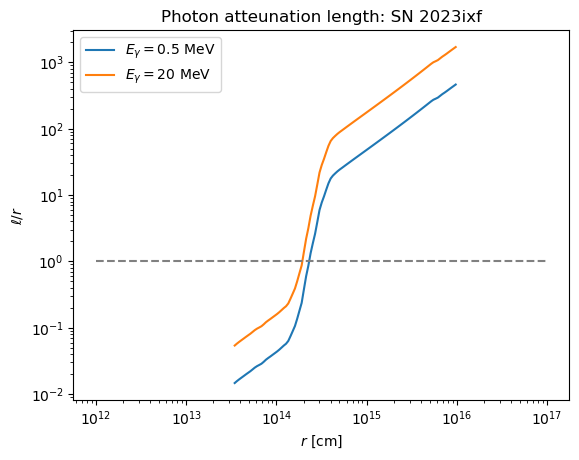

In [88]:
#plt.plot(r_bsg,int_length_bsgcsm1/r_bsg,color='C1',label=r'BSG $\dot{M}=10^{-5}\,M_\odot\,{\rm yr}^{-1}$')
#plt.plot(r_bsg,int_length_bsgcsm2/r_bsg,color='C2',label=r'BSG $\dot{M}=10^{-4}\,M_\odot\,{\rm yr}^{-1}$')
plt.plot(CSM_radii,abs_length_real/CSM_radii,label=r'$E_\gamma=0.5$ MeV')
plt.plot(CSM_radii,abs_length_real_20/CSM_radii,label=r'$E_\gamma=20$ MeV')
#plt.plot(CSM_radii,int_length_real/CSM_radii,label=r'$e^-$ stopping')

plt.plot([r_bsg[0],r_bsg[-1]],[1,1],'--',color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\ell/r$')
plt.legend()
plt.title(r'Photon atteunation length: SN 2023ixf')
#plt.savefig('int_abs_length.png',bbox_inches='tight',dpi=300)

## BELOW IS OBSOLETE

### Constraint

In [45]:
file_path = 'LS220-s18.88/'
#file_path = 'TF-10.8/'
#file_path = 'SFHo-18.8/'
eps_dict = {'1e-11':1e-11,'1e-13':1e-13}
# LS220-s18.88
#time_list = np.array([0.025025958, 0.049998391, 0.074824948, 0.099864677, 0.12498343,0.1500311, 0.17509553, 0.20019816, 0.2248337, 0.24981552, 0.2748468,0.29991753, 0.32495867, 0.35001769, 0.37515225, 0.40005328,0.42519939, 0.44975758, 0.47488252, 0.50006312, 0.75020978,0.99981123, 1.2499211, 1.4998553, 1.7498401, 2.0001881, 2.2500268,2.5001422, 2.7499499, 3.0002358, 3.4997695, 4.0000049, 4.4997671,5.0000058, 5.5001784, 6.0000124, 7.0000407, 8.0001427, 8.9999821,9.9998723, 11.000235])
# TF-10.8
time_list = np.array([0.0, 0.0005071633749998972, 0.001344984198914295, 0.002747482114197092, 0.005360368439765006, 0.009114730681676703, 0.01546656236520411, 0.02377903315351249, 0.0371038998588703, 0.07270743901011611, 0.1559318935712961, 0.1984338428379552, 0.2355246646583827, 0.2696407132612904, 0.2987081452406821, 0.3220030873362578, 0.3494485917853219, 0.4321251343862368, 0.6345777798749864, 0.8290217158061605, 1.148255042476532, 1.530587216869893, 1.850095515413669, 2.025641464550373, 2.291022256907176, 2.494024409449831, 2.776469255304346, 3.069363525669363, 3.181757573705697, 3.38167350130409, 3.589134145372821, 3.911817883753428, 4.300552294421064, 4.685719134837941, 4.982012461146646, 5.268128531663336, 5.64828123539431, 6.108655871270188, 6.606821133770339, 7.106768633770505, 7.606768633770672, 7.636883658096388, 7.646664932038442, 7.660086480352283, 7.666737588615097, 7.690023524550349, 7.82354227734557, 7.828542277345381, 7.833542277345192, 7.838542277345002, 7.844106817969775, 7.849128187336813, 7.854128187336624, 7.859216708957359, 8.070953649197923, 8.527035413357245, 9.013405594743654, 9.50413538884011, 10.00263288883984, 10.49505799144959]) 
# SFHo-18.8
#time_list = np.array([0.025059213, 0.05011927, 0.074826743, 0.09983578, 0.12485604, 0.14986846, 0.17488231, 0.19989878, 0.22491674, 0.24993268, 0.25008736, 0.2749493, 0.30021245, 0.32521253, 0.35011666, 0.37512281, 0.40013599, 0.42514829, 0.45015242, 0.47516306, 0.5001775, 0.74987351, 1.0002234, 1.2500327, 1.4997635, 1.749857, 2.0001179, 2.2501048, 2.5002329, 2.7502406, 3.0001038, 3.4998576, 4.0000753, 4.4999348, 5.0000931, 5.5000477, 5.9999425, 6.9999881, 8.0001694, 8.9998587, 10.000057])
number_of_time_steps = len(time_list)
number_of_r_steps = 41

In [232]:
# load data and reshape
dp_dep_data = np.loadtxt(file_path + 'timeprofile_0_eps_1e-11.dat', skiprows=1)

In [236]:
dp_dep_data = np.array_split(dp_dep_data, 41)

Text(0, 0.5, '$dL/drdt$ [erg cm$^{-1}$ s$^{-1}$]')

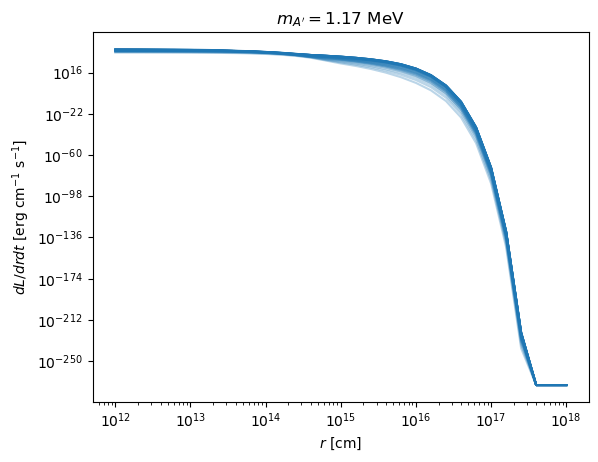

In [262]:
eps_id = eps_dict['1e-10']
mAp_id = 1
for time_id in range(40):
    data = np.loadtxt(file_path + f'timeprofile_{time_id:d}_eps_{eps_id:.0e}.dat')[31*mAp_id :31*(mAp_id +1)]
    mAp_mass = data[1,0]
    log_r = data[:,2]
    dL_T = data[:,3]
    dL_L = data[:,4]
    dL_tot = dL_T + dL_L
    plt.plot(10**log_r,dL_tot,color='C0',alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title(fr'$m_{{A^\prime}}={mAp_mass:.2f}$ MeV')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$dL/drdt$ [erg cm$^{-1}$ s$^{-1}$]')
#plt.savefig('1e-10.pdf',bbox_inches='tight')

### Trapezoidal Rule
We use trapezoidal rule to do the time integration,
$$
\frac{dL}{dr} = \int_{t_{\rm min}}^{t_{\rm max}} dt~\frac{dL}{dt dr} = \frac{1}{2}\sum_{i=0}^{40} \left[\frac{dL}{dt dr}(t_{i+1})+\frac{dL}{dt dr}(t_i)\right](t_{i+1}-t_{i})
$$

In [114]:
eps_id = eps_dict['1e-13']
#mAp_id = 1
dL_int = np.zeros(3731)
for time_id in range(number_of_time_steps-1):
    data_retard = np.loadtxt(file_path + f'timeprofile_{time_id:d}_eps_{eps_id:.0e}_SFHo_more.dat')  # data at time_id
    data_advanced = np.loadtxt(file_path + f'timeprofile_{time_id+1:d}_eps_{eps_id:.0e}_SFHo_more.dat')  # data at (time_id + 1)
    #mAp_mass = data[1,0]
    #log_r = data[:,2]
    # dL at time_id
    dL_T_retard = data_retard[:,3]
    dL_L_retard = data_retard[:,4]
    dL_tot_retard = dL_T_retard + dL_L_retard
    # dL at (time_id + 1)
    dL_T_advanced = data_advanced[:,3]
    dL_L_advanced = data_advanced[:,4]
    dL_tot_advanced = dL_T_advanced + dL_L_advanced
    # Delta t
    dt = time_list[time_id + 1] - time_list[time_id]
    # time integration at this delta t
    dL_int += (dL_tot_advanced + dL_tot_retard) * dt
    #plt.plot(10**log_r,dL_tot,color='C0',alpha=0.3)

In [116]:
test=np.hstack(((data_retard.T[:3]).T,dL_int.reshape(-1,1)))

In [118]:
np.savetxt(file_path + 'time_integrated/time_int_eps_1e-13.txt',test,fmt='%.5e',header = 'mAp [MeV]  epsilon []  r [cm]  (dQ/drdt)*dt [erg/cm]')

In [120]:
data_time_int_1e11 = np.loadtxt(file_path + 'time_integrated/time_int_eps_1e-11.txt')

In [124]:
for i in range(91):
    data = data_time_int_1e13[41*i :41*(i +1)]
    mAp_mass = data[1,0]
    dL_time_int = data[:,3]
    
    log_r = data[:,2]
    plt.plot(10**log_r,dL_time_int,color='C0')
    plt.xscale('log')
    plt.yscale('log')
    #plt.title(fr'$m_{{A^\prime}}={mAp_mass:.2f}$ MeV')
    plt.xlabel(r'$r$ [cm]')
    plt.ylabel(r'$dL/dr$ [erg cm$^{-1}$]')
    plt.ylim(dL_time_int.max()/1e20,30*dL_time_int.max())
    plt.title(fr'$\varepsilon=10^{{-11}}$ and $m_{{A^\prime}}=${mAp_mass:.3f} MeV')
    plt.savefig(file_path + f'figs/1e-11/eps_1e-11_mAp_{mAp_mass:.3f}_MeV.pdf',bbox_inches='tight')
    plt.close()

Scaling relation of time-integrated energy deposition for arbitrary $\epsilon$ from a reference $\epsilon_0$
$$
\frac{dQ}{dr}(\epsilon,r)=\left(\frac{\epsilon}{\epsilon_{0}}\right)^{4}\frac{dQ}{dr}(\epsilon_{0},(\epsilon/\epsilon_{0})^{2}r)
$$

In [31]:
number_of_mAp_mass = 91
def total_energy_deposition(mAp_i,r_min,r_max,eps_list = [1e-11]):

    # Grid number of CSM radius in (1e12,1e20) cm in log-scale
    r_grids = 41
    # Load time-integrated data
    data_eps_1e_minus_13 = np.loadtxt(file_path + 'time_integrated/time_int_eps_1e-13.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-13
    data_eps_1e_minus_11 = np.loadtxt(file_path + 'time_integrated/time_int_eps_1e-11.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-11
    
    # Data arrangement
    mAp_mass = data_eps_1e_minus_13[1,0]
    log_r = data_eps_1e_minus_13[:,2]
    dQ_time_int_1e_minus_13_log10 = np.log10(data_eps_1e_minus_13[:,3]) # log10(energy deposition) for eps = 1e-13
    dQ_time_int_1e_minus_11_log10 = np.log10(data_eps_1e_minus_11[:,3]) # log10(energy deposition) for eps = 1e-11
    # interpolation
    dQ_minus_13_log10 = interp1d(log_r,dQ_time_int_1e_minus_13_log10)
    dQ_minus_11_log10 = interp1d(log_r,dQ_time_int_1e_minus_11_log10)
    dQ_minus_13 = lambda r: 10**dQ_minus_13_log10(np.log10(r))
    dQ_minus_11 = lambda r: 10**dQ_minus_11_log10(np.log10(r))

    # dL for arbitrary eps and r
    def dQ(eps,r):
        try:
            # try reference eps = 1e-11 first
            scaling = (eps / 1e-11)**4
            r_p = (eps / 1e-11)**2 * r
            return scaling * dQ_minus_11(r_p)
        except:
            # try reference eps = 1e-13
            scaling = (eps / 1e-13)**4
            r_p = (eps / 1e-13)**2 * r
            return scaling * dQ_minus_13(r_p)

    energy_dep_list = []
    for eps in eps_list:
        energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
        energy_dep_list.append(energy_dep)
    return energy_dep_list

In [87]:
Q_tot_eps13 = [total_energy_deposition(i,5e14,2e15,eps_list = [1e-13]) for i in range(91)]
Q_tot_eps12 = [total_energy_deposition(i,5e14,2e15,eps_list = [1e-12]) for i in range(91)]

In [63]:
mAp_axis = np.logspace(0,np.log10(501.1872),91)

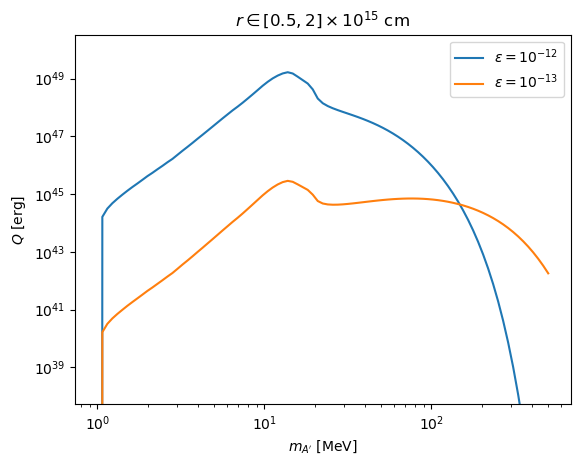

In [101]:
plt.plot(mAp_axis,Q_tot_eps12,label=r'$\epsilon=10^{-12}$')
plt.plot(mAp_axis,Q_tot_eps13,label=r'$\epsilon=10^{-13}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5.2e37,3.3e50)
plt.legend()
plt.xlabel(r'$m_{A^\prime}$ [MeV]')
plt.ylabel(r'$Q$ [erg]')
plt.title(r'$r\in [0.5,2]\times 10^{15}$ cm')
plt.savefig('Q_extend_wind.png',bbox_inches='tight')

In [205]:
eps_list = np.logspace(-13.5,-10,100)
energy_dep_grid = []
for i in range(91):
    ene_dep = total_energy_deposition(i,3e13,3e14,eps_list = eps_list)
    energy_dep_grid.append(ene_dep)
energy_dep_grid = np.array(energy_dep_grid).T

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/2896271674.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/2896271674.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/2896271674.py:36: IntegrationWarni

In [207]:
np.savetxt(file_path + 'Q_tot/Q_tot.txt',energy_dep_grid,fmt='%5e')

In [75]:
# SN1987a gamma
sn1987a_gamma_data = np.loadtxt('sn1987a_gamma.txt',delimiter=',')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/3904611980.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg


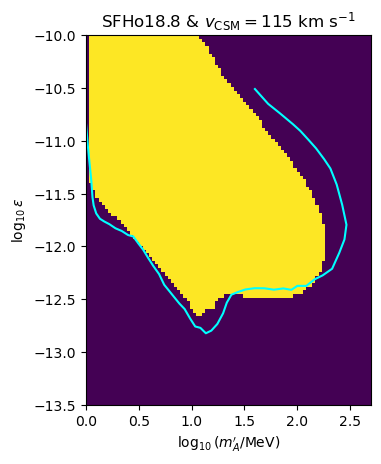

In [132]:
v_csm = 115 # km/s
M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
Q_th = np.log10((v_csm*1e5/light_speed)**2*M_CSM/2)

plt.imshow(np.log10(energy_dep_grid)>Q_th,extent=[0, np.log10(501.187), -13.5, -10],origin='lower')
plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],color='cyan')
#plt.xlim(0,3)
#plt.ylim(-13,-10)
plt.xlabel(r'$\log_{10}(m_{A}^\prime/{\rm MeV})$')
plt.ylabel(r'$\log_{10}\epsilon$')
plt.title(r'SFHo18.8 & $v_{\rm CSM}=115$ km s$^{-1}$')
#plt.title(fr'$M_{\rm CSM}=0.066M_\odot$ & $v_{\rm CSM}\leq {v_csm:%d}$ km s$^{-1}$')
plt.savefig('CSM_constraint_SFHo18.8_v115.pdf',bbox_inches='tight')

In [250]:
# Load total energy deposition data and taking log10
log_Q_tot_LS220 = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot.txt')/2)
log_Q_tot_TF = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot.txt')/2)
log_Q_tot_SFHo = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot.txt')/2)
# Preparing axis values
mAp_axis = np.logspace(0,np.log10(501.1872),91)
eps_axis = np.logspace(-13.5,-10,100)
mAp_mesh,eps_mesh = np.meshgrid(mAp_axis,eps_axis)

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/2647585917.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_21246/2647585917.py:14: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn

Text(0, 0.5, '$\\epsilon$')

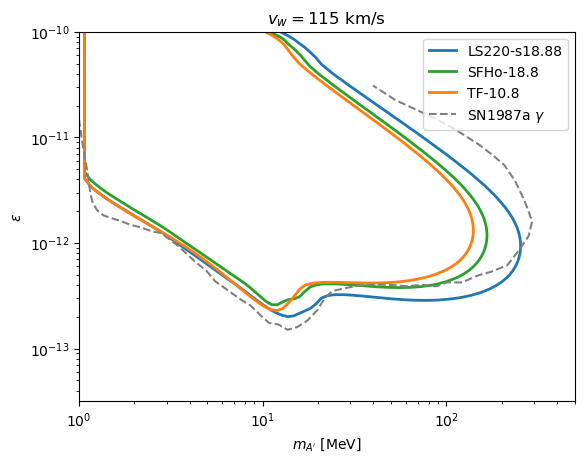

In [254]:
v_csm = 115 # km/s
M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density_real(r),min_r,max_r,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
Q_th = np.log10((v_csm*1e5/light_speed)**2*M_CSM/2)

# contour_SFHo = plt.contourf(X_mesh, Y_mesh, Z, 
#                            levels=20, 
#                            cmap='viridis',
#                            )

target_contour_LS220 =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220, 'r:', levels=[Q_th], linewidths=0)
target_contour_TF =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_TF, 'r:', levels=[Q_th], linewidths=0)
target_contour_SFHo =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo, 'r:', levels=[Q_th], linewidths=0)

for collection in target_contour_LS220.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

plt.plot(10**sn1987a_gamma_data.T[0],10**sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
plt.title(fr'$v_w={v_csm:d}$ km/s')
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{A^\prime}$ [MeV]')
plt.ylabel(r'$\epsilon$')
#plt.savefig(f'DP_constraint_vw{v_csm:d}.pdf',bbox_inches='tight')

In [293]:
3731/41

91.0

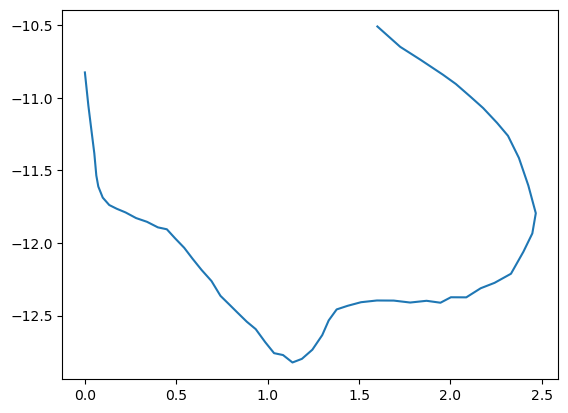

In [31]:
def dEdx(r,Ek,target='H'):
    S = stopping_power_electron(Ek,target)
    rho = CSM_density_real(r)
    return rho * S # MeV/cm

def total_energy_loss_rate(x0,xmax,Ek,target='H'):
    loss_rate = quad(lambda r: dEdx(r,Ek,target),x0,xmax)[0] / Ek
    return min(1,loss_rate)

In [55]:
min_r = 5e14
max_r = 2e15
CSM_r = np.logspace(np.log10(min_r),np.log10(max_r),200)
Ek_10 = [total_energy_loss_rate(x0,max_r,10,target='H') for x0 in CSM_r]
# Ek_30 = [total_energy_loss_rate(x0,max_r,30,target='H') for x0 in CSM_r]
# Ek_100 = [total_energy_loss_rate(x0,max_r,100,target='H') for x0 in CSM_r]
# Ek_250 = [total_energy_loss_rate(x0,max_r,250,target='H') for x0 in CSM_r]

(0.00032, 0.364431987406513)

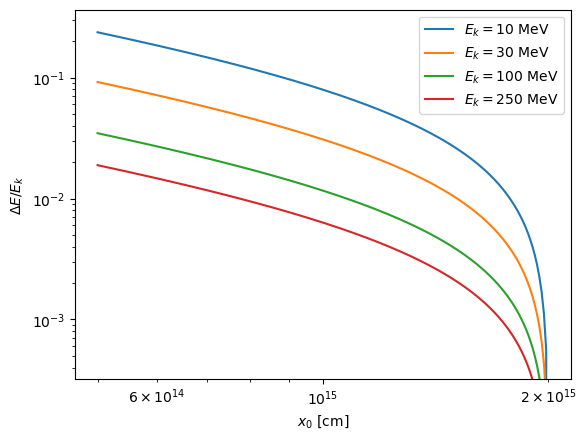

In [57]:
plt.plot(CSM_r,Ek_10,label=r'$E_k=10$ MeV')
plt.plot(CSM_r,Ek_30,label=r'$E_k=30$ MeV')
plt.plot(CSM_r,Ek_100,label=r'$E_k=100$ MeV')
plt.plot(CSM_r,Ek_250,label=r'$E_k=250$ MeV')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$x_0$ [cm]')
plt.ylabel(r'$\Delta E/E_k$')
plt.ylim(3.2e-4,)
#plt.savefig('energy_loss_rate.png',bbox_inches='tight')

In [161]:
total_energy_deposition(34,5e13,4e14,eps_list = [1e-13])

[3.0590316220098417e+44]

In [163]:
624150*2.185747016910885e+44/50

2.7284680012098577e+48

In [167]:
2*624150*2.185747016910885e+44/50/4/np.pi/(6.85*3.08e24)**2

0.0009755654708656401